# Crash Predictive ML Model

We will create a tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

This time we will look at whole city, and use only global variables for city.

In [600]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly_express as px
import plotly

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from modules.myfuncs import *


In [601]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [602]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('int_startend',), ('intersection_chars',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuries_fatal
	injuries_incapacitating

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [603]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [604]:
# This one groups by day for the whole city

all_df = pd.read_sql_query('''WITH v AS(SELECT d.year,
                                                CAST(d.month as TEXT) as month,
                                                d.day,
                                                d.intersection,
                                                dv.violations,
                                                dv.violation_date,
                                                dv.weekday
                                               
                                        FROM all_hours as d

                                        LEFT JOIN daily_violations as dv
                                            ON d.year = dv.year
                                            AND d.month = dv.month
                                            AND d.day = dv.day
                                            AND d.intersection = dv.intersection
                                                
                                        ), 
                                        
                                    ic AS(SELECT intersection,
                                                 region_id
                                        FROM intersection_cams
                                    ),
                                    
                                    cg AS(SELECT year,
                                                 month,
                                                 day,
                                                 region_id,
                                                 AVG(speed) as speed
                                                 
                                            FROM hourly_congestion
                                            GROUP BY year, month, day  
                                    
                                        ),
                                        
                                    cr AS(SELECT SUM(injuries_total) AS injuries,
                                                year,
                                                month,
                                                day,
                                                COUNT(DISTINCT crash_record_id) as n_crash,
                                                SUM(COALESCE(injuries_total,0)) AS injuries,
                                                SUM(injuries_fatal) AS injuries_fatal,
                                                SUM(injuries_incapacitating) AS injuries_incapacitating
                                         FROM signal_crashes
                                         GROUP BY year, month, day
                                        ),
                                        
                                    wx AS(SELECT MAX(temp) AS temp,
                                                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                                                SUM(snow_1h) AS snow_1h,
                                                SUM(rain_1h) AS rain_1h,
                                                year,
                                                month,
                                                day
                                        FROM hourly_weather
                                        GROUP BY year, month, day
                                        )
                                        
                                    SELECT  COUNT(DISTINCT v.intersection) as n_intersection,
                                            v.violation_date,
                                            SUM(v.violations) AS violations,
                                            v.year,
                                            v.month,
                                            v.day,
                                            CAST(v.weekday AS TEXT) AS weekday,
                                            
                                            cr.injuries,
                                            cr.n_crash,
                                            cr.injuries_fatal,
                                            cr.injuries_incapacitating,
                                           
                                            
                                            MAX(wx.temp) as temp,
                                            MAX(wx.precip) as precip,
                                            MAX(wx.snow_1h) as snow,
                                            MAX(wx.rain_1h) as rain,
                                            
                                            cg.speed as congestion                                            
                                            
                                            
                                    FROM v
                                    LEFT JOIN wx
                                        ON wx.year = v.year
                                        AND wx.month = v.month
                                        AND wx.day = v.day

                                    LEFT JOIN cr
                                        ON cr.year = v.year
                                        AND cr.month = v.month
                                        AND cr.day = v.day
                                    LEFT JOIN cg
                                        ON cg.year = v.year
                                        AND cg.month = v.month
                                        AND cg.day = v.day
                                        
                                    WHERE v.violation_date >= \'2017-09-01\'
                                    GROUP BY v.year, v.month, v.day
                                    ORDER BY v.violation_date
                                    ''', conn)


In [605]:
print(all_df.info())
all_df.tail()

all_df.congestion.fillna(all_df.congestion.mean(), inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 16 columns):
n_intersection             1188 non-null int64
violation_date             1188 non-null object
violations                 1188 non-null int64
year                       1188 non-null int64
month                      1188 non-null object
day                        1188 non-null int64
weekday                    1188 non-null object
injuries                   1188 non-null int64
n_crash                    1188 non-null int64
injuries_fatal             1188 non-null int64
injuries_incapacitating    1188 non-null int64
temp                       1188 non-null float64
precip                     1188 non-null float64
snow                       1188 non-null float64
rain                       1188 non-null float64
congestion                 1173 non-null float64
dtypes: float64(5), int64(8), object(3)
memory usage: 148.6+ KB
None


In [609]:
y = all_df['violations'].fillna(0)

drop_cols = ['violation_date', 'day', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'n_crash', 'violations']

X = all_df.drop(columns=drop_cols) 


In [610]:
all_df.n_crash.sum()


48551

In [611]:
#X.week = X.week.astype(int)
# Change crash to a boolean value
y = y.astype(int)

In [612]:
all_df['n_crash'].value_counts()
#165550 / 5245
#5245 / 137
#137/10

X = pd.get_dummies(X)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 26 columns):
n_intersection    1188 non-null int64
year              1188 non-null int64
temp              1188 non-null float64
precip            1188 non-null float64
snow              1188 non-null float64
rain              1188 non-null float64
congestion        1188 non-null float64
month_1           1188 non-null uint8
month_10          1188 non-null uint8
month_11          1188 non-null uint8
month_12          1188 non-null uint8
month_2           1188 non-null uint8
month_3           1188 non-null uint8
month_4           1188 non-null uint8
month_5           1188 non-null uint8
month_6           1188 non-null uint8
month_7           1188 non-null uint8
month_8           1188 non-null uint8
month_9           1188 non-null uint8
weekday_0         1188 non-null uint8
weekday_1         1188 non-null uint8
weekday_2         1188 non-null uint8
weekday_3         1188 non-null uint8
weekday_4

### Would like to do some feature elimination
Doing this for the Boruta

In [613]:
# accept the RFE results automatically
#X = X.drop(columns=auto_drop) 


### Train test split

In [614]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Baseline Tree

In [615]:
# Instantiate and fit a DecisionTreeClassifier
#np.random.seed(337)

tree_clf = DecisionTreeClassifier() 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [616]:
tree_clf.feature_importances_


array([0.10691438, 0.05594587, 0.16756853, 0.08537093, 0.02044011,
       0.06063566, 0.14745225, 0.00784095, 0.03159191, 0.02011673,
       0.01184362, 0.01159835, 0.01858635, 0.0251208 , 0.01975212,
       0.00504643, 0.01063344, 0.01225895, 0.01096577, 0.02652827,
       0.01727091, 0.02688326, 0.02908271, 0.02844916, 0.02260879,
       0.01949374])

In [618]:
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (baseline_errors / y_test)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [620]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center', color='purple') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [621]:
from sklearn.model_selection import GridSearchCV


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [5, 8, 12],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  4.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [622]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 121.1247.
Accuracy = 91.29%.


In [623]:
print(best_grid)
print(grid_accuracy)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
91.28563215673036


In [624]:
# Instantiate and fit a RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(criterion='mse',
                                max_depth=8,
                                max_features=8,
                                min_samples_leaf=2,
                                min_samples_split=8,
                                n_estimators=1000,
                                random_state=42,
                                #class_weight='balanced',
                                #class_weight={0:100, 1:2, 2:1, 3:1},
                               )  # tuned for population



forest.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

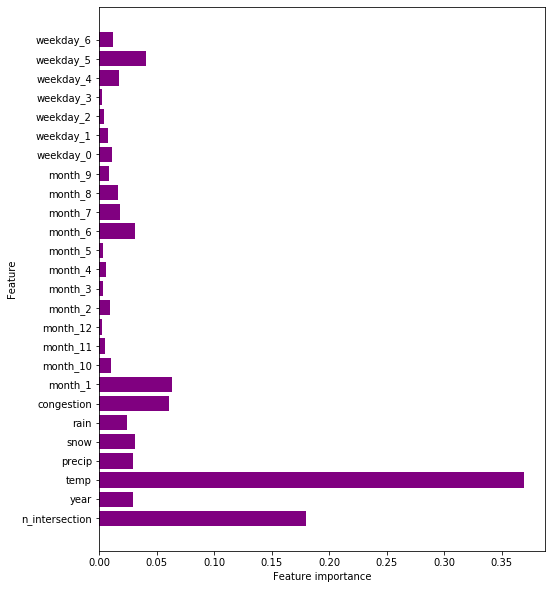

In [625]:
plot_feature_importances(best_grid)


In [626]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating the Algorithm

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

pred = best_grid.predict(X_test)

print('Mean Absolute Error: {:.1f}'.format(mean_absolute_error(y_test, pred))) 
print('Mean Absolute Percentage: {:.1%}'.format(mean_absolute_percentage_error(y_test, pred)))
print('Mean Squared Error: {:.0f}'.format(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error: {:.1f}'.format(np.sqrt(mean_squared_error(y_test, pred))))

Mean Absolute Error: 121.1
Mean Absolute Percentage: 8.7%
Mean Squared Error: 24311
Root Mean Squared Error: 155.9


count    1188.000000
mean     1482.322391
std       328.179281
min       543.000000
25%      1234.000000
50%      1457.500000
75%      1706.250000
max      3118.000000
Name: violations, dtype: float64


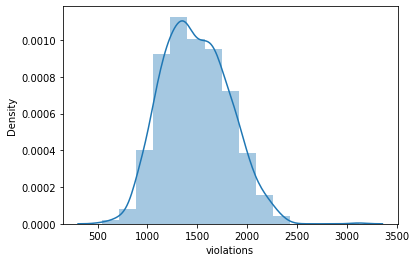

In [627]:
print(y.describe())
sns.distplot(y, bins=15)


In [628]:
pred = best_grid.predict(X)

In [629]:
all_df['violation_date'] = pd.to_datetime(all_df['violation_date'])


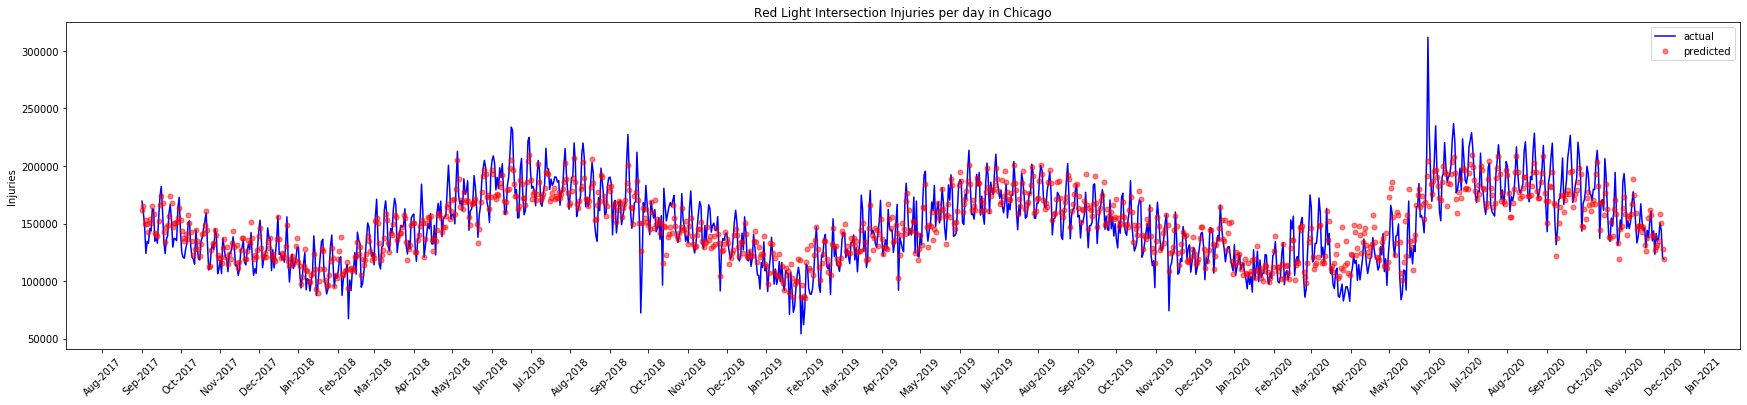

In [630]:
# Use datetime for creating date objects for plotting
# Import necessary packages
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import pandas as pd



# Plot the actual values
fig, ax = plt.subplots(figsize=[30,6])
ax.plot(all_df['violation_date'], y*100, 'b-', label = 'actual')


plt.xticks(rotation=45)


# # Plot the predicted values
plt.plot(all_df['violation_date'], pred*100, 'r.', markersize=10, alpha=0.5, label = 'predicted')
plt.legend()

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Graph labels
plt.ylabel('Injuries')
plt.title('Red Light Intersection Injuries per day in Chicago')

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))


plt.show()

In [631]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 16 columns):
n_intersection             1188 non-null int64
violation_date             1188 non-null datetime64[ns]
violations                 1188 non-null int64
year                       1188 non-null int64
month                      1188 non-null object
day                        1188 non-null int64
weekday                    1188 non-null object
injuries                   1188 non-null int64
n_crash                    1188 non-null int64
injuries_fatal             1188 non-null int64
injuries_incapacitating    1188 non-null int64
temp                       1188 non-null float64
precip                     1188 non-null float64
snow                       1188 non-null float64
rain                       1188 non-null float64
congestion                 1188 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(8), object(2)
memory usage: 148.6+ KB


In [632]:
import plotly.express as px

all_df2 = all_df.copy()
all_df2['pred'] = pred
all_df2['revenue'] = all_df2['violations'] * 100

fig = px.line(all_df2, x='violation_date', y='violations', width=1000, height=400,
             hover_data=["violations", "temp", 'precip', 'weekday'],
             )
fig.add_scatter(x=all_df2.violation_date, y=all_df2.pred, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                  yaxis_title="Violations",
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()

# Let's do same with crashes

In [633]:
y = all_df['n_crash'].fillna(0)

drop_cols = ['violation_date', 'day', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'n_crash']

X = all_df.drop(columns=drop_cols) 

In [634]:
#X.week = X.week.astype(int)
# Change crash to a boolean value
y = y.astype(int)

In [635]:
print(all_df['n_crash'].value_counts().describe())

X = pd.get_dummies(X)
X.info()


count    65.000000
mean     18.276923
std      16.997709
min       1.000000
25%       3.000000
50%      12.000000
75%      32.000000
max      68.000000
Name: n_crash, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 27 columns):
n_intersection    1188 non-null int64
violations        1188 non-null int64
year              1188 non-null int64
temp              1188 non-null float64
precip            1188 non-null float64
snow              1188 non-null float64
rain              1188 non-null float64
congestion        1188 non-null float64
month_1           1188 non-null uint8
month_10          1188 non-null uint8
month_11          1188 non-null uint8
month_12          1188 non-null uint8
month_2           1188 non-null uint8
month_3           1188 non-null uint8
month_4           1188 non-null uint8
month_5           1188 non-null uint8
month_6           1188 non-null uint8
month_7           1188 non-null uint8
month_8          

### Train test split

In [636]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Baseline Tree

In [637]:
# Instantiate and fit a DecisionTreeClassifier
#np.random.seed(337)

tree_clf = DecisionTreeClassifier() 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [638]:
tree_clf.feature_importances_


array([0.09213313, 0.14364051, 0.05392065, 0.15435202, 0.05295826,
       0.01911778, 0.05404214, 0.15764201, 0.00596254, 0.02631223,
       0.01068462, 0.00785166, 0.01029259, 0.00618289, 0.01135047,
       0.01409011, 0.01201505, 0.0057205 , 0.01012795, 0.02238453,
       0.02848091, 0.01482665, 0.02233281, 0.02774575, 0.00280374,
       0.02001126, 0.01301723])

In [639]:
from sklearn.metrics import mean_squared_error

pred = tree_clf.predict(X)
mse = mean_squared_error(y, pred)
np.sqrt(mse)

7.339414374935058

In [640]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center', color='purple') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [641]:
from sklearn.model_selection import GridSearchCV


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': [8, 12, 15],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [500, 750, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
#                       max_features=12, max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=3, min_samples_split=12,
#                       min_weight_fraction_leaf=0.0, n_estimators=500,
#                       n_jobs=None, oob_score=False, random_state=None,
#                       verbose=0, warm_start=False)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [642]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 7.1010.
Accuracy = 80.63%.


In [643]:
print(best_grid)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=12, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [644]:
# Instantiate and fit a RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(criterion='mse',
                                max_depth=8,
                                max_features=8,
                                min_samples_leaf=2,
                                min_samples_split=8,
                                n_estimators=1000,
                                random_state=42,
                                #class_weight='balanced',
                                #class_weight={0:100, 1:2, 2:1, 3:1},
                               )  # tuned for population



forest.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

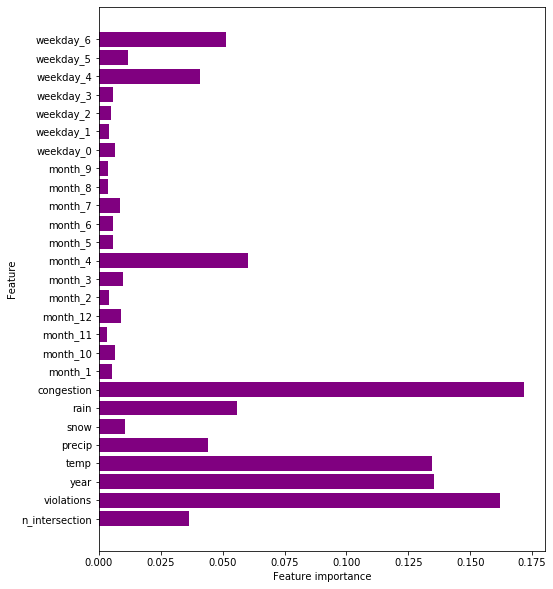

In [645]:
plot_feature_importances(best_grid)


In [646]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating the Algorithm

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

pred = best_grid.predict(X_test)

print('Mean Absolute Error: {:.1f}'.format(mean_absolute_error(y_test, pred))) 
print('Mean Absolute Percentage: {:.1%}'.format(mean_absolute_percentage_error(y_test, pred)))
print('Mean Squared Error: {:.0f}'.format(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error: {:.1f}'.format(np.sqrt(mean_squared_error(y_test, pred))))

Mean Absolute Error: 7.1
Mean Absolute Percentage: 19.4%
Mean Squared Error: 77
Root Mean Squared Error: 8.8


In [647]:
pred = best_grid.predict(X)

In [648]:
all_df['violation_date'] = pd.to_datetime(all_df['violation_date'])


In [649]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 16 columns):
n_intersection             1188 non-null int64
violation_date             1188 non-null datetime64[ns]
violations                 1188 non-null int64
year                       1188 non-null int64
month                      1188 non-null object
day                        1188 non-null int64
weekday                    1188 non-null object
injuries                   1188 non-null int64
n_crash                    1188 non-null int64
injuries_fatal             1188 non-null int64
injuries_incapacitating    1188 non-null int64
temp                       1188 non-null float64
precip                     1188 non-null float64
snow                       1188 non-null float64
rain                       1188 non-null float64
congestion                 1188 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(8), object(2)
memory usage: 148.6+ KB


In [650]:
import plotly.express as px

all_df2 = all_df.copy()
all_df2['pred'] = pred

fig = px.line(all_df2, x='violation_date', y='n_crash', width=1000, height=400,
             hover_data=["violations", "temp", 'precip', 'weekday'],
             )
fig.add_scatter(x=all_df2.violation_date, y=all_df2.pred, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()

# Let's do same with injuries

In [651]:
y = all_df['injuries'].fillna(0)

drop_cols = ['violation_date', 'day', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'n_crash']

X = all_df.drop(columns=drop_cols) 

In [652]:
#X.week = X.week.astype(int)
# Change crash to a boolean value
y = y.astype(int)

In [653]:
print(all_df['injuries'].value_counts().describe())

X = pd.get_dummies(X)


count    40.000000
mean     29.700000
std      26.750701
min       1.000000
25%       4.000000
50%      23.000000
75%      49.000000
max      79.000000
Name: injuries, dtype: float64


### Train test split

In [654]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Baseline Tree

In [655]:
# Instantiate and fit a DecisionTreeClassifier
#np.random.seed(337)

tree_clf = DecisionTreeClassifier() 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [656]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center', color='purple') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [657]:
from sklearn.model_selection import GridSearchCV


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': [8, 12, 15],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [8, 12, 15],
    'n_estimators': [500, 750, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [658]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_grid = grid_search.best_estimator_


print("Base Model:")
base_accuracy = evaluate(tree_clf, X_test, y_test)

print("\nGrid CV Best:")
grid_accuracy = evaluate(best_grid, X_test, y_test)

Base Model:
Model Performance
Average Error: 7.3081.
Accuracy = 43.44%.

Grid CV Best:
Model Performance
Average Error: 4.9834.
Accuracy = 57.75%.


In [659]:
print(best_grid)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=750,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [660]:
# Instantiate and fit a RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(criterion='mse',
                                max_depth=8,
                                max_features=8,
                                min_samples_leaf=2,
                                min_samples_split=8,
                                n_estimators=1000,
                                random_state=42,
                                #class_weight='balanced',
                                #class_weight={0:100, 1:2, 2:1, 3:1},
                               )  # tuned for population



forest.fit(X_train, y_train)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

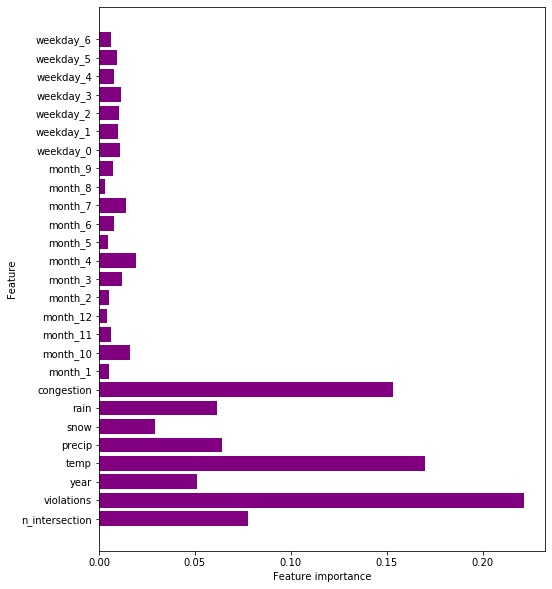

In [661]:
plot_feature_importances(best_grid)


In [662]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating the Algorithm

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

pred = best_grid.predict(X_test)

print('Mean Absolute Error: {:.1f}'.format(mean_absolute_error(y_test, pred))) 
print('Mean Absolute Percentage: {:.1%}'.format(mean_absolute_percentage_error(y_test, pred)))
print('Mean Squared Error: {:.0f}'.format(mean_squared_error(y_test, pred)))
print('Root Mean Squared Error: {:.1f}'.format(np.sqrt(mean_squared_error(y_test, pred))))

Mean Absolute Error: 5.0
Mean Absolute Percentage: 42.3%
Mean Squared Error: 40
Root Mean Squared Error: 6.3


In [663]:
pred = best_grid.predict(X)

In [664]:
all_df['violation_date'] = pd.to_datetime(all_df['violation_date'])


In [665]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 16 columns):
n_intersection             1188 non-null int64
violation_date             1188 non-null datetime64[ns]
violations                 1188 non-null int64
year                       1188 non-null int64
month                      1188 non-null object
day                        1188 non-null int64
weekday                    1188 non-null object
injuries                   1188 non-null int64
n_crash                    1188 non-null int64
injuries_fatal             1188 non-null int64
injuries_incapacitating    1188 non-null int64
temp                       1188 non-null float64
precip                     1188 non-null float64
snow                       1188 non-null float64
rain                       1188 non-null float64
congestion                 1188 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(8), object(2)
memory usage: 148.6+ KB


In [666]:
import plotly.express as px

all_df2 = all_df.copy()
all_df2['pred'] = pred

fig = px.line(all_df2, x='violation_date', y='injuries', width=1000, height=400,
             hover_data=["violations", "temp", 'precip', 'weekday'],
             )
fig.add_scatter(x=all_df2.violation_date, y=all_df2.pred, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()